<center>Заметка 3. Классификация на примере распознавания рукописных цифр.</center>
<center>курса <q>Введение в машинное обучение</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.14</center>

<center>Аннотация</center>
<p>
Вводятся понятие классификации на базе библиотек scikit-learn.
Рассмотрены как минимум следующие классификаторы:
svm (Support Vector Machine, метод опорных векторов) включая ядровый трюк,
MLP (Multi-layer Perceptron, Многослойный перцептрон, нейронные сети),
SGD (Stochastic Gradient Descent, Стохастический градиентный спуск)
и
RidgeClassifier (ridge classification, гребневый классификатор).
В процессе изложения показано насколько важную роль играют параметры того или иного метода.
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import numpy.polynomial.polynomial as poly
import scipy.optimize as opt

from numpy import random as rand

Задача классификации является частным случаем общей формулировке задачи машинного обучения показаной в самой первой заметке про регрессии. Так, в задаче лкассификации считается, что регрессия строится для конечного, при этом существенно небольшого колличества чисел.
Фактически значения образуют дискретное множество или просто конечное множество объектов.
Интерпретация такая. По признакам строится прогноз нечисловой, а элементу из множества.
Например, по признакам (где обитает, сколько весит в взослом состоянии, сколько ног и так дале) определить животное.
Или как в примере из прошлой заметке определить название цветка ириса.

Пусть наша модель задается параметризуется: $f_\theta$. Задача подбора параметров тогда формулируется так:
$$
\theta^* = \underset{\theta}{\operatorname{argmin}}\sum_{i=1}^{i=N}(f_{\theta}(x_i) - y_i )^2 = \underset{\theta}{\operatorname{argmin}} \mathcal{L}(\theta).
$$

Преобразуем минимизационную задачу.
Введем $l(\hat{y}, y) = (\hat{y}- y)^2$,
тогда
$$
\mathcal{L}(\theta) = \sum_{i=1}^{i=N}(f_{\theta}(x_i) - y_i )^2 = \sum_{i=1}^{i=N}l(f_{\theta}(x_i), y_i ).
$$

Как и ранее было упомянуто l можно выбирать под задачу.

Задача классификации заключается в предсказании класса объекта. Классов объектов "немного", задаются дискретным множеством.
В простом случае рассматривается бинарная задача, когда есть два класса.
Например,
что
* сдаст студент экзамен,
* будет или нет по кредиту просрочка
и так далее.

В таких задачах значение у $y$ может быть
* -1 и 1
* 0 и 1.

Для случая бинарной классификации берут
$$
l(\hat{y}, y) = [\hat{y} \neq y] =
\begin{cases}
0 & \hat{y} = y\\
1 & \hat{y} \neq y
\end{cases}  
$$
Но данная функция не дифференцируема, значит методом градиентного спуска не минимизировать.

Приходим к важному принципу.
Есть функция метрика, которую мы на самом деле хотим минимизировать.
Но для применения оптимизационных методов берут другую дифференцируемую функцию,
которую и минимизируют.

Какие варианты для значений функции $f_{\theta}$?
Отмечу, что в случае задания $l(\hat{y}, y)$ для $\hat{y}$ фактически имеются два варианта значения.
Иначе говоря можно было бы эквивалентно задать две функции.
Если же класса равноправны, то хотелось бы одной.

В случае бинарной классификации один из вариантов это считать, что число $0$ разбивает на два класса.
Так,
если $f_{\theta}(x) >0$, то $x$ принадлежит первому классу,
а если $f_{\theta}(x)<0$, то второму.
Случай $f_{\theta}(x)=0$ считается неопределенным.
Если придерживаться того, что классам соответствует значение y $1$ и $-1$,
то величина $m$ всегда положительна ($m=yf_{\theta}(x)>0$) для правильных данных.
В этом смысле, данная величина характеризует величину ошибки.
Если величина $m$ (margin) положительна, то ошибки фактически нет.
Если она отрицательно ($m=yf_{\theta}(x)<0$), то обозначает ошибку.
Поэтому, можно величину $m$ и использовать для построения функции потерь.

<h1>Линейные модели</h1>

Линейные модели как следует из названия предполагают, что данные линейной разделимы -- речь про бинарную классификацию.
Так, существует гипер-плоскость такая что по одну сторону будут элементы одного класса, а по другую другого.

В случае линейных моделей
$$
f_{\theta}(x)= f_{\omega,b}(\vec{x}) = \sum_{j=1}^{j=k}\omega_j\vec{x}_j+b = \omega\cdot x +b,
$$где
$\theta = \{\omega,b\}$ и $x=\vec{x}\in R^k$.

Далее будет рассматривать случай $k=2$.

Берем формулу из второй заметки, которую мы минимизируем, и считаем, что сама функция принимает два значения6 -1 и 1. 1 для одного класса, а -1 для другого.
Ествественно значения не будут идеальными. Например, значению может быть равно 1.1 или 0.8 для класса 1.

Как и ранее ищится минимум данной фкнции. Но теперь вадно обратить внимание на функцию потерь.
В зависимости от того какая будет выбрана будет зависеть и качественый результат по сути.
А точнее некотрым из фукнций потерь соответвуют те или иные традиционные методы классификации.
Так, логорифмическая ункция потерь даст логистическую регрессию.

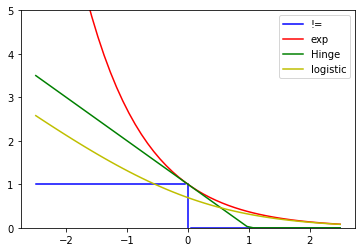

In [2]:
yfx = np.linspace(-2.5, 2.5, 50)

yfxn = yfx[yfx<0]
yfxp = yfx[yfx>=0]
plt.plot( yfxn, 1!=(yfxn>=0), 'b-', label='!=')
plt.plot( yfxp, 1!=(yfxp>=0), 'b-')
plt.plot( [0,0],[0,1],'b-')

plt.plot( yfx, np.exp(-yfx), 'r-', label='exp')

v = 1 - yfx
v[v<0] = 0
plt.plot( yfx, v, 'g-', label='Hinge')

plt.plot( yfx, np.log(1+np.exp(-yfx)), 'y-', label='logistic')

plt.ylim(0, 5)
plt.legend();

<h2>Линейно разделимые</h2>

<b>Сформируем данные</b>

Для начала рассмотрим линейно разделимые.

In [3]:
def gen_rnd_blob(n, s):
    #n = 100
    dat = np.stack([10*rand.randn(n), rand.randn(n)])
    #dat1.shape
    return dat

In [4]:
def get_rot_matrix(a):
    return np.array([[np.cos(a), -np.sin(a)],
                     [np.sin(a), np.cos(a)]])

In [5]:
dat1 = gen_rnd_blob( 100, 10)
dat1_ = get_rot_matrix( 0.15 ).dot(dat1) + np.array([[1.5,-1.5]]).T

dat2 = gen_rnd_blob( 100, 10)
dat2_ = get_rot_matrix( 0.15 ).dot(dat2) + np.array([[-1.5,1.5]]).T

dat1_.shape, dat2_.shape

((2, 100), (2, 100))

In [6]:
def plot_data( dat1_, dat2_, k, b):
    plt.plot( *dat1_, 'b*')
    plt.plot( *dat2_, 'r*')
    x = np.linspace(-30, 30, 50)
    y = k*x + b
    plt.plot(x, y, 'g-')
    plt.legend(['класс 1', 'класс 2']);

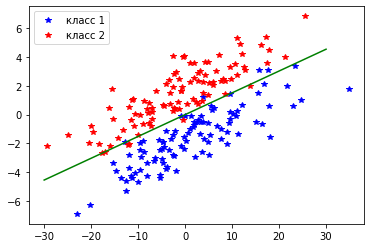

In [7]:
plot_data( dat1_, dat2_, np.tan(0.15), 0)

<b>Подготовим данные для минимизации функции</b>

Так обычно и делают, для машинного обучения.

In [8]:
dat = np.hstack([dat1_, dat2_]).T
y = np.hstack([np.ones(dat1_.shape[1]), -np.ones(dat2_.shape[1])])
dat.shape, y.shape

((200, 2), (200,))

In [9]:
perm = rand.permutation(dat.shape[0])
perm.shape

(200,)

In [10]:
X = dat[perm,:]
Y = y[perm]
X.shape, y.shape

((200, 2), (200,))

In [11]:
(X.T*Y).shape

(2, 200)

<h3>Экспоненциальная функция потерь</h3>
Например, можно воспользоваться экспонентной.
Так, при больших положительных значениях, функция имеет большое значение (стремящиеся к бесконечности),
а при маленьких маленькое (стремящиеся к нулю).
Тогда мы могли бы взять величину $q=e^{-m}$.
Чем более уверенный будет решение решающей функции ($m$ не просто положительная, стремится к положительной бесконечности),
то тем меньше будет величина $q$,
а значит тем меньше будет вклад в ошибку.
И наоборот, тем сильнее решающая функция ошибается, тем меньше величина $m$,
тогда величина $q$ будет неограниченно большой.

$$
l(f_{\theta}(x_i), y_i ) = e^{-y_if_{\theta}(x_i)} = e^{-y_i(\omega \cdot x_i + b)}
$$

$$
\mathcal{L}(\theta) = \sum_{i=1}^{i=N}l(f_{\theta}(x_i), y_i ) = \sum_{i=1}^{i=N}e^{-y_i(\omega \cdot x_i + b)}.
$$

In [12]:
class myExp:
    def __init__(self, x, y, k=0):
        self.x = x
        self.y = y
        self.k = k
        
    def loss(self, d):
        fx = np.sum( self.x.T * d[1:, None], axis=0) + d[0]
        #print(fx.shape)
        yfx = self.y*fx
        #print(  yfx.shape)
        v = np.exp(-yfx)
        #print(v.shape)
        er = np.mean( v )
        #print(er)
        return er + self.k*np.sum(d**2)

In [13]:
X.shape, Y.shape

((200, 2), (200,))

In [14]:
my = myExp(X, Y)

In [15]:
ans = opt.minimize( my.loss, np.array([1.1, -0.5, 0.5]) )
ans

      fun: 0.16203191163291478
 hess_inv: array([[ 6.19452664,  0.22207231, -2.05651927],
       [ 0.22207231,  0.76544475, -4.19931245],
       [-2.05651927, -4.19931245, 24.91648089]])
      jac: array([ 8.67992640e-07, -7.24568963e-07, -1.37835741e-07])
  message: 'Optimization terminated successfully.'
     nfev: 180
      nit: 41
     njev: 45
   status: 0
  success: True
        x: array([ 0.079003  ,  0.49532331, -2.83583373])

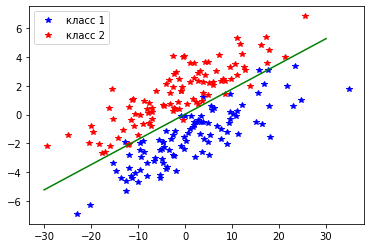

In [16]:
plot_data( dat1_, dat2_, -(ans.x[1]/ans.x[2]), -ans.x[0]/ans.x[2] )

In [17]:
ans = opt.minimize( my.loss, np.array([-1.1, -0.5, 0.5]) )
ans

      fun: 0.16203191163147868
 hess_inv: array([[ 6.09983703,  0.23051365, -2.06372909],
       [ 0.23051365,  0.78553682, -4.3683563 ],
       [-2.06372909, -4.3683563 , 25.98280381]])
      jac: array([4.17232513e-07, 5.86174428e-06, 9.74163413e-07])
  message: 'Optimization terminated successfully.'
     nfev: 336
      nit: 78
     njev: 84
   status: 0
  success: True
        x: array([ 0.07899906,  0.49532356, -2.83583258])

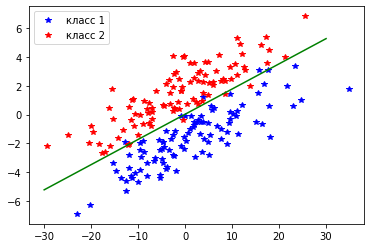

In [18]:
plot_data( dat1_, dat2_, -(ans.x[1]/ans.x[2]), -ans.x[0]/ans.x[2] )

In [19]:
# Построить на одном графике много прямых? Имеет смысл в случа линейной разделимости.

Сделаем предсказание

In [20]:
np.sum(ans.x[1:]*X[33]) + ans.x[0]

4.442980984062376

In [21]:
def get_preds( X, d, labels = False):
    preds = []
    for x in X:
        v = np.sum(d[1:]*x) + d[0]
        preds.append(v)
    #len(preds)
    preds = np.array(preds)
    if labels:
        preds[ preds <= 0 ] = -1
        preds[ preds > 0 ] = 1
    return preds 

In [22]:
preds = get_preds( X, ans.x)
len(preds)

200

In [23]:
preds[:10]

array([-0.66793626,  0.24670147,  0.8445661 , -2.14640505,  8.01733152,
        8.3729741 , -0.79313362,  2.91002517,  3.39906565, -2.42592444])

In [24]:
marg = preds*Y # margins

Доля правильных ответов

In [25]:
np.mean(marg>0)

0.96

In [26]:
preds = get_preds( X, ans.x, True)
len(preds)

200

In [27]:
preds[:10]

array([-1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.])

In [28]:
np.mean( preds == Y )

0.96

In [29]:
np.mean( get_preds( X, ans.x, True) == Y )

0.96

Вспомним про регуляризацию.

In [30]:
my = myExp(X, Y, k=1)

In [31]:
ans = opt.minimize( my.loss, np.array([-1.1, -0.5, 0.5]) )
ans

      fun: 0.7063013674537688
 hess_inv: array([[ 0.37745932,  0.00038272, -0.00085338],
       [ 0.00038272,  0.02378626, -0.04508134],
       [-0.00085338, -0.04508134,  0.29261575]])
      jac: array([-2.83122063e-07,  4.32133675e-07,  3.27825546e-07])
  message: 'Optimization terminated successfully.'
     nfev: 272
      nit: 60
     njev: 68
   status: 0
  success: True
        x: array([-0.00282659,  0.07043916, -0.36600339])

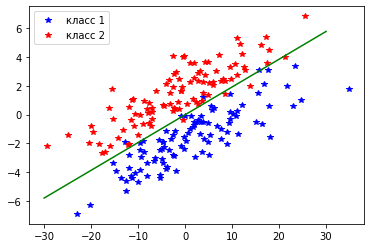

In [32]:
plot_data( dat1_, dat2_, -(ans.x[1]/ans.x[2]), -ans.x[0]/ans.x[2] )

In [33]:
ans = opt.minimize( my.loss, np.array([1.1, -0.5, 0.5]) )
ans

      fun: 0.7063013674537421
 hess_inv: array([[ 3.90510327e-01, -8.87497136e-05,  2.24832633e-03],
       [-8.87497136e-05,  2.32469943e-02, -4.17899073e-02],
       [ 2.24832633e-03, -4.17899073e-02,  2.65681705e-01]])
      jac: array([ 7.45058060e-09,  1.41561031e-07, -1.04308128e-07])
  message: 'Optimization terminated successfully.'
     nfev: 132
      nit: 27
     njev: 33
   status: 0
  success: True
        x: array([-0.00282648,  0.07043917, -0.3660035 ])

In [34]:
np.mean( get_preds( X, ans.x, True) == Y )

0.96

Есть стабильность...

<h3>Hinge</h3>
Метод опорных векторов.
$$
l(f_{\theta}(x_i), y_i ) = \max\{{0, 1-y_if_{\theta}(x_i)}\} = \max\{0, 1 - y_i(\omega \cdot x_i + b)\}
$$

In [35]:
class myHinge:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def loss(self, d):
        fx = np.sum( self.x.T * d[1:, None], axis=0) + d[0]
        yfx = self.y*fx
        v = 1 - yfx
        #print(v.shape)
        v[v<0] = 0
        er = np.mean( v )
        #print(er)
        return er #+ 0.5*np.sum(d**2)

    def dloss(self, d):
        v = 1 - (np.sum( self.x.T * d[1:, None], axis=0) + d[0]) * self.y
        vx = -(self.x.T*self.y).T
        vy = -self.y.T
        vx[v<0] = 0
        vy[v<0] = 0
        er = np.mean( vx, axis=0 )
        #print('erQ', er.shape)#vx.shape, er.shape, vy.shape)
        return np.array([np.mean(vy), *er]) #+ 0.5*2*d

In [36]:
X.shape, Y.shape

((200, 2), (200,))

In [37]:
my = myHinge(X, Y)# может copy?

In [38]:
ans = opt.minimize( my.loss, np.array([-0.1, -0.5, 0.5]) ) #, method="CG"
ans

      fun: 0.09149723356224662
 hess_inv: array([[ 1.06606144e-04, -9.45963152e-05,  1.04216617e-04],
       [-9.45963152e-05,  8.53961588e-05, -9.39363054e-05],
       [ 1.04216617e-04, -9.39363054e-05,  1.03355096e-04]])
      jac: array([-0.00010593,  0.00138823,  0.00149357])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 560
      nit: 15
     njev: 137
   status: 2
  success: False
        x: array([ 0.06974961,  0.44660096, -2.52683769])

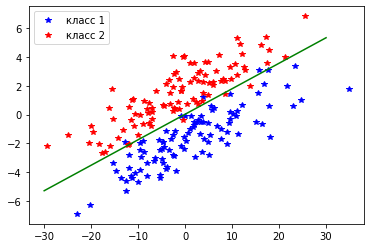

In [39]:
plot_data( dat1_, dat2_, -(ans.x[1]/ans.x[2]), -ans.x[0]/ans.x[2] )

In [40]:
ans = opt.minimize( my.loss, np.array([-0.9, -1.5, 0.5]) ) #, method="CG"
ans

      fun: 0.09146834499204179
 hess_inv: array([[ 7.03975600e-07, -8.12484614e-07,  1.49697812e-06],
       [-8.12484614e-07,  8.74341748e-06, -1.03497945e-05],
       [ 1.49697812e-06, -1.03497945e-05,  1.47371324e-05]])
      jac: array([0.00391292, 0.0081701 , 0.00085334])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 805
      nit: 19
     njev: 200
   status: 2
  success: False
        x: array([ 0.11020227,  0.43185328, -2.41397621])

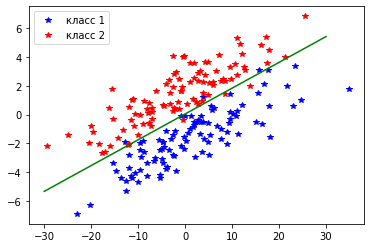

In [41]:
plot_data( dat1_, dat2_, -(ans.x[1]/ans.x[2]), -ans.x[0]/ans.x[2] )

In [42]:
np.mean( get_preds( X, ans.x, True) == Y )

0.965

<b>Производная</b>

In [43]:
ans = opt.minimize( my.loss, np.array([-0.9, -1.5, 0.5]), jac=my.dloss ) # method="CG"
ans

      fun: 0.09152716551595562
 hess_inv: array([[ 0.98894662, -0.01567807,  0.06784199],
       [-0.01567807,  0.39090919, -1.95773815],
       [ 0.06784199, -1.95773815, 10.07058741]])
      jac: array([0.        , 0.0081701 , 0.00085334])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 62
      nit: 12
     njev: 56
   status: 2
  success: False
        x: array([ 0.0880031 ,  0.44523136, -2.47313174])

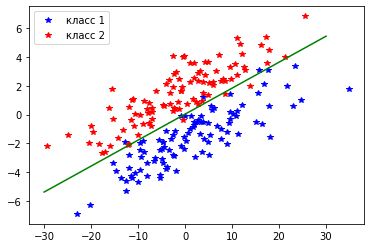

In [44]:
plot_data( dat1_, dat2_, -(ans.x[1]/ans.x[2]), -ans.x[0]/ans.x[2] )

In [45]:
np.mean( get_preds( X, ans.x, True) == Y )

0.965

<h3>Библиотечный вызов</h3>

In [46]:
from sklearn import linear_model 

In [47]:
# Общий метод градиентного скуска.
# Характеристики зависят от функции потерь.
clf = linear_model.SGDClassifier(loss='hinge')

In [48]:
X.shape, Y.shape

((200, 2), (200,))

In [49]:
#Y[Y==-1]=0

In [50]:
#X = [[0, 0], [1, 1]] # Две точки на двумерной плоскости.
#y = [0, 1]?? -1 not 0?? # Им соответсвуют данные классы.

In [51]:
clf.fit(X, Y)

SGDClassifier()

In [52]:
clf.coef_

array([[  28.48104459, -184.9149614 ]])

In [53]:
clf.intercept_

array([5.932641])

In [54]:
d = [*clf.intercept_, *clf.coef_[0]]
d

[5.932641004410925, 28.481044591618204, -184.91496140412391]

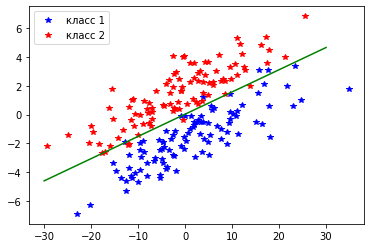

In [55]:
plot_data( dat1_, dat2_, -(d[1]/d[2]), -d[0]/d[2] )

In [56]:
np.mean( get_preds( X, d, True) == Y )

0.955

In [57]:
# Теперь можно предсказывать:
p = [-4,-5] # Проверим класс для данной точки.
clf.predict( [p] ) # В общем случае передает список. Поэтому в квадратных скобках.

array([1.])

In [58]:
clf.predict( [[4,5]] )

array([-1.])

In [59]:
np.mean( clf.predict( X ) == Y )

0.955

In [60]:
v = get_preds( X, d, True) == clf.predict( X )
v.shape

(200,)

In [61]:
clf.predict( [X[6]] )

array([-1.])

In [62]:
np.mean(d[1:]*X[6]) + d[0]

-3.547748991750069

In [63]:
np.mean( get_preds( X, d, True) == Y )

0.955

Для конкретных методов есть более оптимальный алгоритм из вычисления.

<b>Через оптимальное управление</b>

Детали дам на отдельной лекции.

In [64]:
from sklearn.svm import LinearSVC as SVC

In [65]:
clf = SVC(loss='hinge', C=1)#0.0001 1000
clf

LinearSVC(C=1, loss='hinge')

In [66]:
clf.fit(X, Y)

/data/conda/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, loss='hinge')

In [67]:
clf.intercept_

array([0.06855043])

In [68]:
clf.coef_

array([[ 0.39860385, -2.21795979]])

In [69]:
d = [*clf.intercept_, *clf.coef_[0]]
d

[0.06855043392054343, 0.39860385259199255, -2.2179597938932476]

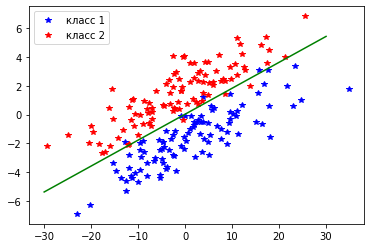

In [70]:
plot_data( dat1_, dat2_, -(d[1]/d[2]), -d[0]/d[2] )

<h3>Логистическая регрессия</h3>

$$
l(f_{\theta}(x_i), y_i ) = \log\{1+e^{-y_if_{\theta}(x_i)}\} = \log\{1+e^{-y_i(\omega \cdot x_i + b)}\} 
$$

In [71]:
class myLog:
    def __init__(self, x, y, k=0):
        self.x = x
        self.y = y
        self.k = k
        
    def loss(self, d):
        fx = np.sum( self.x.T * d[1:, None], axis=0) + d[0]
        #print(fx.shape)
        yfx = self.y*fx
        #print(  yfx.shape)
        v = np.log(1 + np.exp(-yfx))
        er = np.mean( v )
        return er + self.k*np.sum(d**2)

In [72]:
my = myLog(X, Y, k=1)

In [73]:
ans = opt.minimize( my.loss, np.array([-1.1, -0.5, 0.5]) )
ans

      fun: 0.5679225547183014
 hess_inv: array([[ 0.45041085,  0.00067784,  0.00438828],
       [ 0.00067784,  0.04462893, -0.04831203],
       [ 0.00438828, -0.04831203,  0.34762415]])
      jac: array([7.45058060e-09, 2.23517418e-08, 2.23517418e-08])
  message: 'Optimization terminated successfully.'
     nfev: 52
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([-0.00090382,  0.0607708 , -0.28104741])

In [74]:
d = ans.x
d[1]/d[2]

-0.2162296917102005

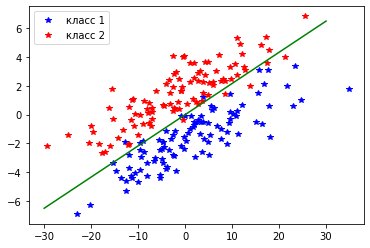

In [75]:
plot_data( dat1_, dat2_, -(d[1]/d[2]), -d[0]/d[2] )

In [76]:
# По умолчанию loss равен hinge
clf = linear_model.SGDClassifier(loss='log') # Теперь будет логисчическая регрессия.
clf

SGDClassifier(loss='log')

In [77]:
clf.intercept_, clf.coef_

AttributeError: 'SGDClassifier' object has no attribute 'intercept_'

In [78]:
clf.fit( X, Y)

SGDClassifier(loss='log')

In [79]:
clf.intercept_, clf.coef_

(array([7.05468209]), array([[  40.85855651, -261.43502366]]))

In [80]:
d = [*clf.intercept_, *clf.coef_[0]]
d

[7.054682091682194, 40.858556509706645, -261.43502365556924]

In [81]:
d[1]/d[2]

-0.15628570318694654

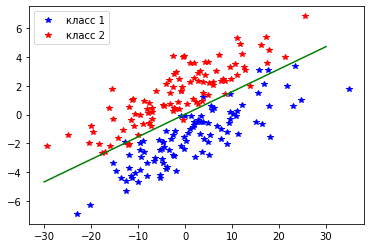

In [82]:
plot_data( dat1_, dat2_, -(d[1]/d[2]), -d[0]/d[2] )

In [83]:
#clf = linear_model.RidgeClassifier()
#clf.fit( X, y)

Различные функции потерь

In [84]:
# !Сравнить модели
# Разбиение на тестовое и обуч мнодство биб фнукией
# k-fold

<h2>Классификация на примере изображений рукописных цифр.</h2>

Изоражение рукописных цифр имеет фисированный рамер. изображение черное белое (скорее даже градации серого).
Изображение как известно харакетезуется его размером: некое колличество пикселов в ширину и в высоту.
Фактически изображение является матрицей чисел.
Признаками являются сами пикселы, т.е. отдельные элементы из которых изображение состоит.
Их общее количество будет ширина умноденная на высоту.

Рассмотрим одну из классическиз задачь... определение цифры по  изображению её рукописной заиси.
Иначе говоря на вход будет подаватся изображение с рукописной цифрой (от 0 до 9). С точки зрения постановки задачи важно, что ничего друго не может быть там написано быть. т.е. гарантируется что одна из фифр (и только одна) изображена.
Так вот по изображению нужно определить цифру.

In [85]:
from sklearn.datasets import load_digits # Данные для цифр

In [86]:
# Загружаем датасет из изображений рукописных чисел.
digits = load_digits()

Смотрим что находится в данных.
На основании того что там есть решить отдкуда брать изображения и метки (правильные ответы).

In [87]:
# Смотрим ключи "словаря"
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [88]:
# Это очевидно метки.  
digits['target'] # target стандартное название для них.

array([0, 1, 2, ..., 8, 9, 8])

In [89]:
# Проверим нашу интуицию. 
np.unique(digits['target']) # Тут должны быть только цифры от 0 до 9.
# И ничего больше! (конечно, только для данного датасета)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [90]:
digits['target'].shape

(1797,)

Это вроде сами изображения.
проверим что количество элементов в массиве images совпдает с количеством ответов.

In [91]:
digits['images'].shape
# Видно даже, что размер каждого изображения 8 на 8.

(1797, 8, 8)

In [92]:
# Отобразим матрицу изображения.
digits['images'][74] # матрица 8 на 8.

array([[ 0.,  0., 13., 13.,  8.,  2.,  0.,  0.],
       [ 0.,  5., 16., 16., 16., 12.,  0.,  0.],
       [ 0.,  1., 15., 12.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 12., 13.,  7.,  1.,  0.,  0.],
       [ 0.,  0.,  8., 16., 16., 12.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  9., 16.,  3.,  0.],
       [ 0.,  0.,  1.,  5., 14., 15.,  1.,  0.],
       [ 0.,  0., 10., 16., 16.,  6.,  0.,  0.]])

Вывдеим матрицы изображения виде картинки для лучшего понимания.

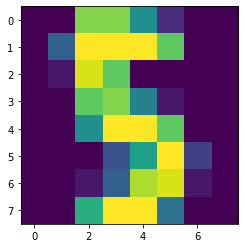

In [93]:
dig = digits['images'][74]
plt.imshow( dig ) # Картинка цветная и вводит в заблуждение.

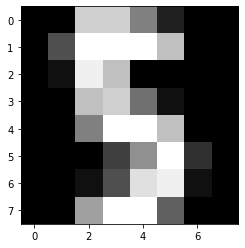

In [94]:
dig = digits['images'][74]
plt.imshow( dig, cmap='gray' ) # Картинка цветная и вводит в заблуждение.

In [95]:
dig = digits['images'][74]
img = np.stack([dig, dig, dig])
img.shape

(3, 8, 8)

In [96]:
img = np.moveaxis(img, 0, 2)
img.shape

(8, 8, 3)

In [97]:
np.max(img)

16.0

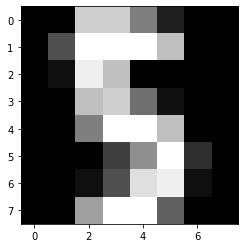

In [98]:
plt.imshow( img/16 ); # Картинка цветная и вводит в заблуждение.

Посмотрим какой должен быть правильным ответ.

In [99]:
digits['target'][74]

5

Сделаем все-таки изображения в градациях серого.

In [100]:
img = np.zeros((dig.shape[0], dig.shape[1], 3))
img[:,:,0] = dig
img[:,:,1] = dig
img[:,:,2] = dig
np.max(img), img.shape # Вычислил максимум значения изображения и тип.
# Видими, что изображение имеет всего 16 градаций.

(16.0, (8, 8, 3))

In [101]:
img.dtype

dtype('float64')

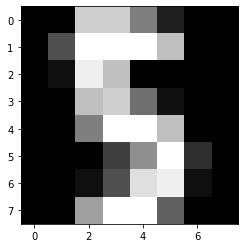

In [102]:
img /= 16 # Отнормируем изображение (так чтобы максимум был равен 1). #np.max(img)
plt.imshow( img ) # Теперь выглядит как надо.

В данном массиве по суте хранятся названия для людей.
В более сложном датасете они были бы более осмысленными.
В даном они совпадабт с самими метками.

In [103]:
digits['target_names']

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<h3>Один класс против другого</h3>

In [104]:
digits['data'].shape

(1797, 64)

In [105]:
digits['target'].shape

(1797,)

In [106]:
dat1_ = digits['data'][digits['target']==5]
dat2_ = digits['data'][digits['target']==4]
dat1_.shape, dat2_.shape

((182, 64), (181, 64))

In [107]:
dat = np.vstack([dat1_, dat2_])
y = np.hstack([np.ones(dat1_.shape[0]), -np.ones(dat2_.shape[0])])
dat.shape, y.shape

((363, 64), (363,))

In [108]:
perm = rand.permutation(dat.shape[0])
perm.shape

(363,)

In [109]:
X = dat[perm,:]
Y = y[perm]
X.shape, y.shape

((363, 64), (363,))

In [110]:
X.shape, Y.shape

((363, 64), (363,))

In [111]:
my = myHinge(X, Y)# может copy?

In [112]:
ans = opt.minimize( my.loss, np.random.randn(65) ) #, method="CG"
ans

      fun: 0.0
 hess_inv: array([[ 9.99684862e-01,  0.00000000e+00, -5.28203616e-04, ...,
        -9.70611066e-04, -4.79857262e-05,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.28203616e-04,  0.00000000e+00,  9.97913719e-01, ...,
         2.35678330e-03,  1.63137335e-05,  0.00000000e+00],
       ...,
       [-9.70611066e-04,  0.00000000e+00,  2.35678330e-03, ...,
         1.00555400e+00,  3.09186104e-04,  0.00000000e+00],
       [-4.79857262e-05,  0.00000000e+00,  1.63137335e-05, ...,
         3.09186104e-04,  9.99993664e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [113]:
d = ans.x
d

array([-0.28569462, -1.74691079,  2.29597578,  2.2603936 , -1.18517276,
        1.25673365,  0.52148886,  1.1574651 , -0.09295296, -0.97170855,
        0.53548691,  0.45233224,  0.44741588,  0.84319012, -0.69000367,
       -0.67150097,  0.4392923 ,  1.13726865,  0.03934768,  0.6241828 ,
       -0.64337569, -0.95718426, -0.21818036, -0.51363034,  0.40761332,
       -0.00723585,  0.8338206 ,  0.75190628, -0.51659274,  0.33456677,
       -0.38292872, -0.12480611,  0.79328178, -0.91424504, -2.09287219,
       -1.37215536, -0.98566228,  0.08092123, -0.46539588,  0.66592982,
       -1.93325335,  0.81470616, -0.9461749 ,  1.18214882, -0.95529872,
       -0.23220297, -0.53614083, -2.56623178,  0.33394564, -1.74212994,
       -0.55903205, -0.35545213, -0.80469581,  0.82623833,  0.7794479 ,
       -0.80267228, -1.59789447,  0.13586653,  1.73944244, -0.93627633,
        1.52879075, -0.67339528,  1.01369244,  0.62701808,  2.04719097])

In [114]:
x = X[55]
x

array([ 0.,  0.,  0.,  3., 16.,  3.,  0.,  0.,  0.,  0.,  0., 12., 16.,
        2.,  0.,  0.,  0.,  0.,  8., 16., 16.,  4.,  0.,  0.,  0.,  7.,
       16., 15., 16., 12., 11.,  0.,  0.,  8., 16., 16., 16., 13.,  3.,
        0.,  0.,  0.,  0.,  7., 14.,  1.,  0.,  0.,  0.,  0.,  0.,  6.,
       16.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 14.,  0.,  0.,  0.])

In [115]:
np.sum(d[1:]*x) + d[0], 

(-39.29427405509878,)

In [116]:
Y[55]

-1.0

In [117]:
Y.shape

(363,)

In [118]:
np.where(Y>0)

(array([  1,   3,   5,   6,   7,   8,  12,  13,  15,  17,  20,  22,  23,
         25,  26,  27,  28,  35,  38,  39,  40,  43,  46,  49,  52,  54,
         57,  64,  65,  68,  69,  72,  73,  76,  77,  78,  80,  82,  86,
         87,  88,  92,  93,  94,  95,  98,  99, 100, 103, 104, 105, 106,
        108, 109, 113, 115, 118, 121, 122, 125, 128, 129, 130, 131, 132,
        134, 135, 137, 138, 139, 141, 143, 148, 149, 151, 152, 156, 158,
        163, 164, 165, 167, 168, 170, 171, 172, 175, 177, 181, 186, 187,
        188, 190, 191, 193, 194, 195, 197, 198, 199, 200, 201, 202, 204,
        205, 207, 211, 212, 216, 217, 218, 221, 222, 223, 226, 227, 228,
        229, 232, 234, 238, 241, 242, 243, 244, 245, 248, 251, 253, 256,
        257, 258, 260, 261, 262, 265, 266, 267, 271, 272, 273, 274, 276,
        277, 278, 281, 282, 284, 285, 289, 290, 292, 295, 298, 300, 301,
        302, 303, 305, 306, 307, 309, 312, 315, 318, 319, 323, 324, 325,
        330, 332, 336, 338, 346, 348, 351, 352, 353

In [119]:
np.sum(d[1:]*X[22]) + d[0], Y[22]

(43.37554070240692, 1.0)

<b>Для начала попробуем линейную модель</b>

In [120]:
def train( clf, data, labels ):
    n = data.shape[0]
    perm = np.random.permutation( n )
    tr_n = int(0.85 * n)
    train = perm[ :tr_n ]
    valid = perm[ tr_n: ]

    train_dig = data[ train ]
    train_lab = labels[ train ]

    valid_dig = data[ valid ]
    valid_lab = labels[ valid ]

    clf.fit( train_dig, train_lab )

    val_cnt = sum( clf.predict( valid_dig ) == valid_lab ) 
    return clf.predict( valid_dig ), valid_lab #val_cnt / valid_lab.shape[0]

In [121]:
clf = linear_model.SGDClassifier(loss='hinge')#svm.LinearSVC() # Вариант для линейных моделей.
pred, valid = train( clf, X, Y)#digits['data'], digits['target'] )
qq = pred == valid
sum(qq)/qq.shape[0]

1.0

Уже прекрасный результат.

In [122]:
clf = linear_model.SGDClassifier(loss='log')
pred, valid = train( clf, X, Y)#digits['data'], digits['target'] )
qq = pred == valid
sum(qq)/qq.shape[0]

0.9818181818181818

In [123]:
qq = pred == valid
#q3q

In [124]:
sum(qq)/qq.shape[0]

0.9818181818181818

In [125]:
clf = linear_model.RidgeClassifier()
pred, valid = train( clf, X, Y)#digits['data'], digits['target'] )
qq = pred == valid
sum(qq)/qq.shape[0]

1.0

<h3>Один класс против всех</h3>

In [126]:
dat1_ = digits['data'][digits['target']==5]
dat2_ = digits['data'][digits['target']!=5]
dat1_.shape, dat2_.shape

((182, 64), (1615, 64))

Второй класс гораздо больше.
Это обычно считается плохо.
Нужно выравнять.

In [127]:
dat2_[::9,:].shape

(180, 64)

In [128]:
dat2_ = dat2_[::9,:]

In [129]:
dat1_.shape, dat2_.shape

((182, 64), (180, 64))

In [130]:
dat = np.vstack([dat1_, dat2_])
y = np.hstack([np.ones(dat1_.shape[0]), -np.ones(dat2_.shape[0])])
dat.shape, y.shape

((362, 64), (362,))

In [131]:
perm = rand.permutation(dat.shape[0])
perm.shape

(362,)

In [132]:
X = dat[perm,:]
Y = y[perm]
X.shape, y.shape

((362, 64), (362,))

In [133]:
X.shape, Y.shape

((362, 64), (362,))

In [134]:
my = myHinge(X, Y)# может copy?

In [135]:
ans = opt.minimize( my.loss, np.random.randn(65) ) #, method="CG"
ans

      fun: 0.0
 hess_inv: array([[ 9.99678558e-01,  0.00000000e+00, -8.91135421e-04, ...,
        -2.25740223e-03,  2.53039246e-03,  3.07670204e-03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.91135421e-04,  0.00000000e+00,  1.01405147e+00, ...,
         3.70079735e-03, -6.47819100e-02, -6.30636397e-02],
       ...,
       [-2.25740223e-03,  0.00000000e+00,  3.70079735e-03, ...,
         8.97352491e-01, -5.60006102e-02, -3.39926912e-02],
       [ 2.53039246e-03,  0.00000000e+00, -6.47819100e-02, ...,
        -5.60006102e-02,  1.26717127e+00,  2.67535747e-01],
       [ 3.07670204e-03,  0.00000000e+00, -6.30636397e-02, ...,
        -3.39926912e-02,  2.67535747e-01,  1.25777669e+00]])
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [136]:
d = ans.x
d

array([-1.10433588,  1.66712576,  1.1735769 ,  1.04423583,  1.08279888,
       -0.29429129,  1.86207538,  0.77004037,  0.27826216, -2.18417513,
        0.79271259,  1.81365887, -0.56451905,  0.88390824,  0.19478878,
       -0.10620786, -1.06903309, -0.04410039, -0.87322524,  1.10000899,
        0.97064436, -1.8074451 , -3.83258614, -1.32016565, -1.07702288,
        0.10590896,  0.59455502,  0.60556539,  1.21165817,  0.12491682,
       -0.63232967, -1.89224324,  0.44265752,  0.68193804, -0.91973744,
        0.66314526, -1.0298359 , -0.10032981,  0.13849515,  1.13293497,
        1.80094053,  0.79317872, -0.39157674, -1.02127198, -2.10306734,
       -1.88445716,  0.6764753 , -0.59853772, -0.91664289,  0.77450508,
       -0.06588464, -1.21624618, -1.54684259,  0.12953744,  0.03835926,
       -0.82189569,  1.43812094, -0.06226264,  1.12704581,  2.04368781,
        0.16021269, -2.89166147, -0.13911975, -0.67311428,  2.00474928])

In [137]:
x = X[55]
x

array([ 0.,  0.,  1., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 10.,  0.,
        0.,  0.,  0.,  0.,  1., 16.,  2.,  0.,  0.,  0.,  0.,  0.,  4.,
       13.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 12.,  4., 11.,  9.,  1.,
        0.,  0.,  4., 16., 15.,  8., 12.,  7.,  0.,  0.,  2., 14., 10.,
        3., 13.,  7.,  0.,  0.,  0.,  2., 13., 16.,  8.,  1.,  0.])

In [138]:
np.sum(d[1:]*x) + d[0], 

(-91.31504524523046,)

In [139]:
Y[55]

-1.0

In [140]:
Y.shape

(362,)

In [141]:
np.where(Y<0)

(array([  1,   4,   5,  10,  13,  16,  17,  18,  23,  24,  26,  27,  28,
         29,  31,  32,  33,  34,  35,  38,  40,  42,  43,  47,  48,  50,
         51,  55,  56,  58,  60,  62,  66,  70,  71,  73,  76,  77,  78,
         81,  82,  83,  86,  88,  90,  92,  94,  96,  97,  99, 102, 105,
        107, 108, 111, 112, 113, 120, 121, 122, 123, 124, 125, 127, 130,
        133, 137, 138, 139, 140, 141, 142, 144, 147, 152, 153, 154, 155,
        156, 159, 164, 167, 168, 169, 171, 173, 174, 176, 178, 179, 180,
        181, 182, 183, 184, 185, 187, 189, 191, 192, 193, 194, 195, 196,
        203, 205, 206, 209, 212, 214, 216, 218, 222, 224, 228, 230, 231,
        235, 236, 237, 239, 240, 248, 253, 254, 256, 262, 264, 265, 266,
        275, 277, 278, 282, 284, 287, 291, 292, 293, 294, 296, 298, 299,
        301, 304, 305, 306, 307, 308, 309, 312, 314, 315, 316, 319, 320,
        323, 325, 327, 328, 329, 331, 334, 337, 338, 339, 340, 341, 343,
        345, 346, 347, 348, 349, 350, 351, 352, 353

In [142]:
np.sum(d[1:]*X[3]) + d[0], Y[3]

(63.13870300666717, 1.0)

<h3>Многоклассовая</h3>

In [143]:
def get_model( num ):
    dat1_ = digits['data'][ digits['target'] == num ]
    dat2_ = digits['data'][ digits['target'] != num ]
    dat2_ = dat2_[::9,:]
    
    dat = np.vstack([dat1_, dat2_])
    y = np.hstack([np.ones(dat1_.shape[0]), -np.ones(dat2_.shape[0])])
    
    perm = rand.permutation(dat.shape[0])
    
    X = dat[perm,:]
    Y = y[perm]
    my = myHinge(X, Y)
    ans = opt.minimize( my.loss, np.random.randn(65) ) #, method="CG"
    return ans

In [144]:
models = []
for i in range(0, 10):
    ans = get_model( i )
    models.append(ans)

In [145]:
def get_pred( x ):
    #x = digits['data'][55]
    g = []
    for i in range(0, 10):
        d = models[i].x
        v = np.sum(d[1:]*x) + d[0],
        g.append( v[0] )
    g = np.array(g)
    a = np.random.choice(np.where(g>0)[0])
    return a

In [146]:
preds = list( map( get_pred, digits['data']) )

In [147]:
len(preds)

1797

In [148]:
targs = digits['target']

<h3>Отображение результатов</h3>

Зафиксируем какой либо класс. Например конкретную цифру.
Два главных понятия:
* precision -- точность: какой процент из предсказанныз цифр является правильным ответом.
* recall -- полнота: какой процент из правильных ответов был верно отвечен.

<b>Разберем синтезированые примеры</b>

Возьмем два вектра чисел.
Правильные ответы: [1,1,1,1,2,1],
и то что быо предсказано [1,2,1,1,2,2].
Правдивость предсказаний: [Да, Нет, Да, Да, Да,Нет].

Выберем класс, например, 1.
Тогда, все места где было предсказано 1, действительно соответсвуют действительности. Значит precision равен 1.
Все ли 1 были предсказаны. Нет, не все. Вторая и последняя 1 не были предсказаны (мы сказали что там 2).
Значит мы верно предсказали 3 из 5 единиц. 3/5=0.6. Значит recall 0.6.

In [149]:
from sklearn import metrics

In [150]:
print( metrics.classification_report( [1,1,1,1,2,1], [1,2,1,1,2,2] ) )

              precision    recall  f1-score   support

           1       1.00      0.60      0.75         5
           2       0.33      1.00      0.50         1

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6



Упр. По аналогии проверьте класс 2.

Разумеется можно запустить и для большего колличества классов.

In [151]:
print( metrics.classification_report( [1,1,0,1,2,1], [0,2,1,1,2,2] ) )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.25      0.33         4
           2       0.33      1.00      0.50         1

    accuracy                           0.33         6
   macro avg       0.28      0.42      0.28         6
weighted avg       0.39      0.33      0.31         6



In [152]:
print( metrics.classification_report( [0,2,2], [1,2,1] ) )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       1.00      0.50      0.67         2

    accuracy                           0.33         3
   macro avg       0.33      0.17      0.22         3
weighted avg       0.67      0.33      0.44         3



/data/conda/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/conda/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/conda/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/conda/

<b>Отчет для обученной модели</b>

In [153]:
print(metrics.classification_report( targs, preds))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       178
           1       0.74      0.74      0.74       182
           2       0.95      0.88      0.91       177
           3       0.75      0.80      0.77       183
           4       0.84      0.74      0.79       181
           5       0.78      0.88      0.83       182
           6       0.90      0.79      0.84       181
           7       0.93      0.81      0.87       179
           8       0.69      0.74      0.71       174
           9       0.73      0.79      0.76       180

    accuracy                           0.81      1797
   macro avg       0.81      0.81      0.81      1797
weighted avg       0.81      0.81      0.81      1797



In [154]:
#Сделать для бибилотечного классификатора

In [155]:
print( metrics.classification_report( pred, valid ) )

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        33
         1.0       1.00      1.00      1.00        22

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55

